<a href="https://colab.research.google.com/github/aanchal0431/chatbot/blob/main/SEP_728_Chatbot_BERT_ft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chatbot

In [121]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os

from sklearn.model_selection import train_test_split

In [91]:
print(tf.__version__)

2.7.0


Git Commands to clone repository, pull and push data

In [92]:
!git clone https://github.com/aanchal0431/chatbot.git
#!git pull
%cd chatbot/
#!git config --global user.name "aanchal0431"
#!git config --global user.email "aanchal0431@gmail.com"
#!git remote add aanchal0431 https://github.com/aanchal0431/chatbot.git
#!git --help
#!git remote -v
#!git init
#%ls
#!git add outputs/
!git status 
#!git commit -m 'Model epoch 1'


Cloning into 'chatbot'...
remote: Enumerating objects: 712, done.
remote: Counting objects: 100% (226/226), done.
remote: Compressing objects: 100% (174/174), done.
remote: Total 712 (delta 62), reused 177 (delta 35), pack-reused 486
Receiving objects: 100% (712/712), 7.18 MiB | 18.12 MiB/s, done.
Resolving deltas: 100% (109/109), done.
/content/chatbot/chatbot
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


### Data Preprocessing - **Cleaning**

*   Load datasets
*   Append question and answer datasets
*   Remove questions with no answers
*   Drop irrelevant columns
*   Remove duplicate questions
*   Convert data to lower case
*   Add context

In [93]:
cur_path = 'Data/Question_Answer_Dataset_v1.2/'
data_s8 = pd.read_csv(cur_path + 'S08/question_answer_pairs.txt', delimiter="\t")
data_s9 = pd.read_csv(cur_path + 'S09/question_answer_pairs.txt', delimiter="\t")
data_s10 = pd.read_csv(cur_path + 'S10/question_answer_pairs.txt', delimiter="\t")
print("Shape s8:", data_s8.shape)
print("Shape s9:", data_s9.shape)
print("Shape s10:", data_s10.shape)
data_s8.head()

Shape s8: (1715, 6)
Shape s9: (825, 6)
Shape s10: (1458, 6)


,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile
0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes,easy,easy,data/set3/a4
1,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,Yes.,easy,easy,data/set3/a4
2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes,easy,medium,data/set3/a4
3,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,Yes.,easy,easy,data/set3/a4
4,Abraham_Lincoln,Did his mother die of pneumonia?,no,easy,medium,data/set3/a4


Append Data

In [94]:
#append all questions into one data set
data_all = data_s8.append(data_s9.append(data_s10))
print("Shape:", data_all.shape)
data_all.head()


Shape: (3998, 6)


,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile
0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes,easy,easy,data/set3/a4
1,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,Yes.,easy,easy,data/set3/a4
2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes,easy,medium,data/set3/a4
3,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,Yes.,easy,easy,data/set3/a4
4,Abraham_Lincoln,Did his mother die of pneumonia?,no,easy,medium,data/set3/a4


Drop irrelevant columns and remove questions without an answer

In [95]:
#remove irrelevant columns
data_all = data_all.drop(labels = ['DifficultyFromQuestioner', 'DifficultyFromAnswerer', 'ArticleFile'], axis = 1)

#drop rows with NULL values
data_all = data_all.dropna(subset=['Answer'])
print("Shape:", data_all.shape)
data_all.head()

Shape: (3422, 3)


,ArticleTitle,Question,Answer
0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes
1,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,Yes.
2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes
3,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,Yes.
4,Abraham_Lincoln,Did his mother die of pneumonia?,no


Remove duplicate questions

In [96]:
#remove duplicate questions
data_all = data_all.drop_duplicates(subset=['Question'])
print("Shape:", data_all.shape)
data_all.head()

Shape: (2203, 3)


,ArticleTitle,Question,Answer
0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes
2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes
4,Abraham_Lincoln,Did his mother die of pneumonia?,no
6,Abraham_Lincoln,How many long was Lincoln's formal education?,18 months
8,Abraham_Lincoln,When did Lincoln begin his political career?,1832


Convert all text to lower case

In [97]:
# convert text to lower case
data_all = data_all.apply(lambda x: x.astype(str).str.lower())
data_all.head()

,ArticleTitle,Question,Answer
0,abraham_lincoln,was abraham lincoln the sixteenth president of...,yes
2,abraham_lincoln,did lincoln sign the national banking act of 1...,yes
4,abraham_lincoln,did his mother die of pneumonia?,no
6,abraham_lincoln,how many long was lincoln's formal education?,18 months
8,abraham_lincoln,when did lincoln begin his political career?,1832


Load Wikipedia article and add to the dataframe

In [98]:
#Add a column containing the context
#create dataset with column
title = []
context = []

#pull context and titles from S08
for y in range (8, 11):   
  for s in range(1, 7):
    for a in range(1, 11):
      file = str('Data/Question_Answer_Dataset_v1.2/S0' + str(y) + '/data/set' + str(s) + '/a' + str(a) + '.txt.clean' )
      if os.path.exists(file):
        article = open(file, encoding = "ISO-8859-1").read()
        context.append(article)
        title.append(article.split('\n')[0])

#create dataframe for context and titles
data_articles = pd.DataFrame({'ArticleTitle': title,
                              'Context': context})

#make lower case
data_articles = data_articles.apply(lambda x: x.astype(str).str.lower())

print("Shape:", data_articles.shape)
data_articles.head()

Shape: (90, 2)


,ArticleTitle,Context
0,kangaroo,kangaroo\n\n\na kangaroo is a marsupial from t...
1,leopard,leopard\n\n\n\nthe leopard (panthera pardus) i...
2,penguin,penguin\n\n\n\na penguin encounters a human du...
3,polar bear,polar bear\n\n\n\nthe polar bear (ursus mariti...
4,elephant,elephant\n\n\n\nelephants (elephantidae) are a...


In [99]:
#replace all _ in titles with spaces
data_all['ArticleTitle'] = data_all['ArticleTitle'].str.replace('_', ' ')
data_articles['ArticleTitle'] = data_articles['ArticleTitle'].str.replace('_', ' ')

#join context into data all
data_all = data_all.merge(data_articles, how='left', on='ArticleTitle')

print("Shape:", data_all.shape)
data_all.head()

Shape: (2755, 4)


,ArticleTitle,Question,Answer,Context
0,abraham lincoln,was abraham lincoln the sixteenth president of...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...
1,abraham lincoln,did lincoln sign the national banking act of 1...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...
2,abraham lincoln,did his mother die of pneumonia?,no,abraham lincoln\n\n\n\nabraham lincoln (februa...
3,abraham lincoln,how many long was lincoln's formal education?,18 months,abraham lincoln\n\n\n\nabraham lincoln (februa...
4,abraham lincoln,when did lincoln begin his political career?,1832,abraham lincoln\n\n\n\nabraham lincoln (februa...


### Explore Data
Check the word length of the answers. How many questions are yes/no questions? What type of question is asked most often?

Single word answers: 1575
Two word answers: 231
Three word answers: 161
Four word answers: 124
Five word answers: 88
6-10 word answers: 341
11-20 word answers: 186
More than 20 words answers: 49

Max answer word length: 156
Max answer string length: 926


<function matplotlib.pyplot.show>

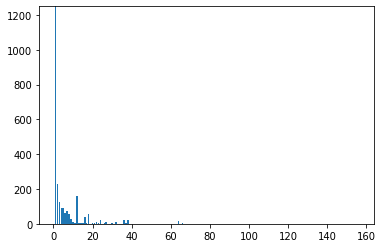

In [100]:
#plot the distribution of answer word length
word_length = data_all['Answer'].str.count(' ') + 1
string_length = data_all['Answer'].str.len()

print('Single word answers:', (word_length == 1).sum())
print('Two word answers:', (word_length == 2).sum())
print('Three word answers:', (word_length == 3).sum())
print('Four word answers:', (word_length == 4).sum())
print('Five word answers:', (word_length == 5).sum())
print('6-10 word answers:', ((word_length > 5) & (word_length <= 10)).sum())
print('11-20 word answers:', ((word_length > 10) & (word_length <= 20)).sum())
print('More than 20 words answers:', (word_length > 20).sum())
print('\nMax answer word length:', word_length.max())
print('Max answer string length:', string_length.max())

#plt.hist(word_length, bins = 100)
plt.bar(word_length.unique(), word_length.value_counts())
plt.ylim([0,1250])
plt.show

In [101]:
#examine types of questions
question_type = data_all['Question'].str.split(' ').str[0]
question_type.value_counts()

what       564
is         395
was        247
how        196
did        193
          ... 
(where       1
whate        1
however      1
based        1
founded      1
Name: Question, Length: 102, dtype: int64

In [102]:
#pull all yes/no questions
yes_no = ['yes', 'yes.', 'yes,', 'no', 'no.', 'no,']
data_yn = data_all.where(data_all['Answer'].str.split(' ').str[0].isin(yes_no)).dropna()
data_yn['Answer'] = data_yn['Answer'].str.split(' ').str[0]

#remove periods & commas
data_yn['Answer'] = data_yn['Answer'].str.replace('.','')
data_yn['Answer'] = data_yn['Answer'].str.replace(',','')

print("Shape:", data_yn.shape)
data_yn.head()

Shape: (1070, 4)


,ArticleTitle,Question,Answer,Context
0,abraham lincoln,was abraham lincoln the sixteenth president of...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...
1,abraham lincoln,did lincoln sign the national banking act of 1...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...
2,abraham lincoln,did his mother die of pneumonia?,no,abraham lincoln\n\n\n\nabraham lincoln (februa...
8,abraham lincoln,did lincoln beat john c. breckinridge in the 1...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...
9,abraham lincoln,was abraham lincoln the first president of the...,no,abraham lincoln\n\n\n\nabraham lincoln (februa...


In [103]:
#pull all other questions that pull "direct" answers from the context
data_context = data_all.where((data_all['Answer'].str.split(' ').str[0].isin(yes_no)) == False).dropna()
data_context.to_csv('Questions_toClean.csv', index=False)
print("Shape:", data_context.shape)
data_context.head()

Shape: (1252, 4)


,ArticleTitle,Question,Answer,Context
3,abraham lincoln,how many long was lincoln's formal education?,18 months,abraham lincoln\n\n\n\nabraham lincoln (februa...
4,abraham lincoln,when did lincoln begin his political career?,1832,abraham lincoln\n\n\n\nabraham lincoln (februa...
5,abraham lincoln,what did the legal tender act of 1862 establish?,"the united states note, the first paper curren...",abraham lincoln\n\n\n\nabraham lincoln (februa...
6,abraham lincoln,who suggested lincoln grow a beard?,11-year-old grace bedell,abraham lincoln\n\n\n\nabraham lincoln (februa...
7,abraham lincoln,when did the gettysburg address argue that ame...,1776,abraham lincoln\n\n\n\nabraham lincoln (februa...


Single word answers: 363
Two word answers: 197
Three word answers: 141
Four word answers: 99
Five word answers: 69
6-10 word answers: 236
11-20 word answers: 116
More than 20 words answers: 31

Max answer word length: 156
Max answer string length: 926


<function matplotlib.pyplot.show>

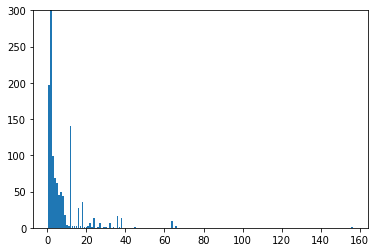

In [15]:
#plot the distribution of answer word length for questions that aren't yes/no
word_length = data_context['Answer'].str.count(' ') + 1
string_length = data_context['Answer'].str.len()

print('Single word answers:', (word_length == 1).sum())
print('Two word answers:', (word_length == 2).sum())
print('Three word answers:', (word_length == 3).sum())
print('Four word answers:', (word_length == 4).sum())
print('Five word answers:', (word_length == 5).sum())
print('6-10 word answers:', ((word_length > 5) & (word_length <= 10)).sum())
print('11-20 word answers:', ((word_length > 10) & (word_length <= 20)).sum())
print('More than 20 words answers:', (word_length > 20).sum())
print('\nMax answer word length:', word_length.max())
print('Max answer string length:', string_length.max())

#plt.hist(word_length, bins = 100)
plt.bar(word_length.unique(), word_length.value_counts())
plt.ylim([0,300])
plt.show

In [104]:
#create type indicator in data set and combine clean yes/no and context
data_yn['Answer Type'] = 'yes/no'
data_context['Answer Type'] = 'context'
data_all = data_yn.append(data_context)

print("Shape:", data_all.shape)
data_all.head()

Shape: (2322, 5)


,ArticleTitle,Question,Answer,Context,Answer Type
0,abraham lincoln,was abraham lincoln the sixteenth president of...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...,yes/no
1,abraham lincoln,did lincoln sign the national banking act of 1...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...,yes/no
2,abraham lincoln,did his mother die of pneumonia?,no,abraham lincoln\n\n\n\nabraham lincoln (februa...,yes/no
8,abraham lincoln,did lincoln beat john c. breckinridge in the 1...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...,yes/no
9,abraham lincoln,was abraham lincoln the first president of the...,no,abraham lincoln\n\n\n\nabraham lincoln (februa...,yes/no


### Data Preprocess - Model preparation

In [157]:
# combine question and context into one column
data_all['QuestionContext'] = 'question:' + data_all['Question'] + 'context:' + data_all["Context"]

# divide into train and test
X_train, X_test, y_train, y_test = train_test_split(data_all['QuestionContext'], data_all['Answer'],
           shuffle=True, test_size=0.1, random_state=5)
# X_train, X_test, y_train, y_test = train_test_split(data_s8['Question'], data_s8['Answer'],
#           shuffle=True, test_size=0.1, random_state=5)
data_all

,ArticleTitle,Question,Answer,Context,Answer Type,QuestionContext
0,abraham lincoln,was abraham lincoln the sixteenth president of...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...,yes/no,question:was abraham lincoln the sixteenth pre...
1,abraham lincoln,did lincoln sign the national banking act of 1...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...,yes/no,question:did lincoln sign the national banking...
2,abraham lincoln,did his mother die of pneumonia?,no,abraham lincoln\n\n\n\nabraham lincoln (februa...,yes/no,question:did his mother die of pneumonia?conte...
8,abraham lincoln,did lincoln beat john c. breckinridge in the 1...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...,yes/no,question:did lincoln beat john c. breckinridge...
9,abraham lincoln,was abraham lincoln the first president of the...,no,abraham lincoln\n\n\n\nabraham lincoln (februa...,yes/no,question:was abraham lincoln the first preside...
...,...,...,...,...,...,...
2740,xylophone,the xylophone is an instrument from what family?,the percussion family,xylophone\n\n\n\nthe xylophone (from the greek...,context,question:the xylophone is an instrument from w...
2741,xylophone,how do the java and bali use xylophones?,in gamelan ensembles,xylophone\n\n\n\nthe xylophone (from the greek...,context,question:how do the java and bali use xylophon...
2742,xylophone,some versions of xylophones have resonators ma...,gourds,xylophone\n\n\n\nthe xylophone (from the greek...,context,question:some versions of xylophones have reso...
2743,xylophone,"which came first, the xylophone or the vibraph...",xylophone,xylophone\n\n\n\nthe xylophone (from the greek...,context,"question:which came first, the xylophone or th..."


In [21]:
#Format for simpleT5

train = pd.DataFrame({'source_text': X_train, 'target_text': y_train})
# Add prefix for simpleT5
# train['source_text']    = "question:" + train['source_text']
test = pd.DataFrame({'source_text': X_test, 'target_text': y_test}) 
#test['source_text']    = "question:" + test['source_text']
train.head()

,source_text,target_text
93,question:what are the similarities between bee...,mouthparts
729,question:are all penguins countershaded?contex...,yes
1040,question:what has uruguay done to be competiti...,"labeling as ""natural"" or ""ecological"""
1074,"question:what defended slavery, owned slaves a...",his father
2216,question:when did isaac newton discover the ge...,in 1665.


Visualize accuracy and loss for the LSTM model

In [ ]:
#function to visualiz results
def plot_results(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_' + metric])
  plt.title('Train and Validation ' + metric)
  plt.xlabel('Epoch')
  plt.ylabel(metric)  
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

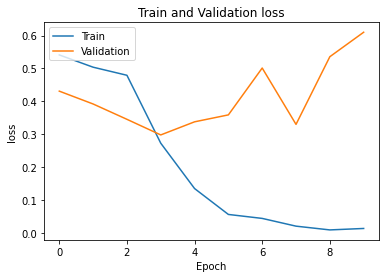

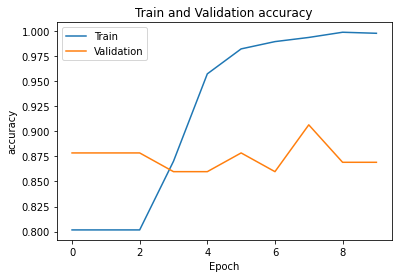

In [ ]:
plot_results(history, "loss")
plot_results(history, "accuracy")

### BERT
Use a pretrained transformer model. Model inputs include the question and context. The model hones in on the relevant context for the answer. It does not provide a yes/no answer. It also is limited by the size of the context. Our context needs to be shortened to use Bert.

In [25]:
!pip install transformers

from transformers import BertTokenizer, AutoTokenizer, BertForQuestionAnswering, AutoModelForQuestionAnswering
import torch

In [43]:
!pip install pyyaml==5.4.1

     |████████████████████████████████| 636 kB 5.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0


In [199]:
# Combine question and context for the BERT model
data_yn['QuestionContext'] = 'question:' + data_yn['Question'] + 'context:' + data_yn["Context"]
data_yn.Answer.replace(to_replace=["no", "yes"], value=[0, 1], inplace=True)
data_yn["Answer"] = data_yn["Answer"].apply(lambda x: list(map(int, x)))
# Number of yes questions and number of no question 866 vs 204
data_yn.head(5)

,ArticleTitle,Question,Answer,Context,Answer Type,QuestionContext
0,abraham lincoln,was abraham lincoln the sixteenth president of...,[1],abraham lincoln\n\n\n\nabraham lincoln (februa...,yes/no,question:was abraham lincoln the sixteenth pre...
1,abraham lincoln,did lincoln sign the national banking act of 1...,[1],abraham lincoln\n\n\n\nabraham lincoln (februa...,yes/no,question:did lincoln sign the national banking...
2,abraham lincoln,did his mother die of pneumonia?,[0],abraham lincoln\n\n\n\nabraham lincoln (februa...,yes/no,question:did his mother die of pneumonia?conte...
8,abraham lincoln,did lincoln beat john c. breckinridge in the 1...,[1],abraham lincoln\n\n\n\nabraham lincoln (februa...,yes/no,question:did lincoln beat john c. breckinridge...
9,abraham lincoln,was abraham lincoln the first president of the...,[0],abraham lincoln\n\n\n\nabraham lincoln (februa...,yes/no,question:was abraham lincoln the first preside...


In [166]:
# split train dataset into train, validation and test sets
train_text, val_text, train_labels, val_labels = train_test_split(data_yn['QuestionContext'], data_yn['Answer'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=data_yn['Answer'])


validation_text, test_text, validation_labels, test_labels = train_test_split(val_text, val_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [167]:
#BERT
BERT_tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
BERT_model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad') 

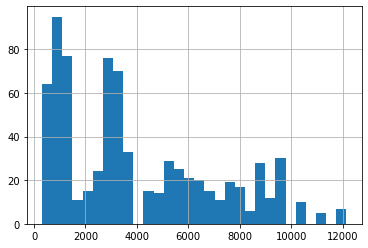

In [168]:
# Encode questions
# get length of all the questions + context in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

Tokenize and encode the question and context for the training, validation and test sets

In [169]:
# tokenize and encode the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 512,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode the validation set
tokens_val = tokenizer.batch_encode_plus(
    validation_text.tolist(),
    max_length = 512,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode  the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 512,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [170]:
## convert lists to tensors

train_sequence = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

validation_sequence = torch.tensor(tokens_val['input_ids'])
validation_mask = torch.tensor(tokens_val['attention_mask'])
validation_y = torch.tensor(validation_labels.tolist())

test_sequence = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

Create dataloaders for the training and validation sets

In [173]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_sequence, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
validation_data = TensorDataset(validation_sequence, validation_mask, validation_y)

# sampler for sampling the data during training
validation_sampler = SequentialSampler(validation_data)

# dataLoader for validation set
val_dataloader = DataLoader(validation_data, sampler = validation_sampler, batch_size=batch_size)

In [175]:
# Freeze all the layers of BERT before fine-tuning it on the data

for param in BERT_model.parameters():
    param.requires_grad = False

Model Architecture for BERT Training

In [177]:
import torch.nn as nn
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

Passing BERT pretrained on large corpus to the model architecture above

In [180]:
model = BERT_Arch(BERT_model)


In [181]:
# AdamW from Hugging face transformers is the opitmizer
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate

In [202]:
# this cell deals with the imbalance between the yes and no questions
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print("Class Weights:",class_weights)

TypeError: ignored

In [74]:

data_context_bert = data_context.filter(['ArticleTitle', 'Question', 'Context'], axis=1)
data_context_bert.drop_duplicates(subset=["ArticleTitle"], keep="first", inplace=True)
data_context_bert.shape
len(data_context_bert.iloc[2,1])
contexts = data_context_bert.Context
data_context_bert.replace('\n', ' ', regex=True)




,ArticleTitle,Question,Context
3,abraham lincoln,how many long was lincoln's formal education?,abraham lincoln abraham lincoln (february 1...
27,amedeo avogadro,who is most noted for his contributions to the...,amedeo avogadro caricature of amedeo avogad...
53,anders celsius,who determined the dependence of the boiling o...,anders_celsius anders celsius the observatory...
88,beetle,what are the three sections of a beetle?,beetle beetles are a group of insects which...
118,calvin coolidge,when did he drop john from his name?,"calvin coolidge john calvin coolidge, jr. (..."
...,...,...,...
2099,drum,how long has the basic design of the drum rema...,"drum bass drum made from wood, rope, and co..."
2175,guitar,where is the headstock located?,guitar the guitar is a musical instrument w...
2543,piano,what is the middle pedal called on grand pianos?,piano baby grand piano the piano is a music...
2627,swahili language,what is the swahili word for the swahili langu...,swahili_language swahili (kiswahili) is the...


In [110]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')


In [111]:
def process_data(row):
  inputs = tokenizer.encode_plus(
      row.Question,
      row.Context,
      max_length=512,
      truncation=True,
      padding='max_length',
      return_tensors='pt'
  )
  return inputs

In [112]:
inputs = data_context_bert.apply(lambda row: process_data(row), axis=1)
inputs.keys()

Int64Index([   3,   27,   53,   88,  118,  145,  176,  205,  223,  250,  275,
             306,  323,  341,  363,  392,  414,  451,  468,  497,  534,  566,
             600,  626,  638,  709,  740,  774,  799,  828,  866,  890,  998,
            1021, 1058, 1090, 1233, 1241, 1250, 1260, 1279, 1300, 1353, 1355,
            1366, 1383, 1396, 1403, 1412, 1418, 1428, 1444, 1504, 1542, 1557,
            1565, 1577, 1639, 1666, 1699, 1715, 1733, 1742, 1802, 1811, 2099,
            2175, 2543, 2627, 2697],
           dtype='int64')

In [32]:
def train_data_yn(row):
  tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')  
  question = row.Question.tolist()
  context = row.Context[0:512].tolist()
  inputs = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors='pt')
  input_ids = inputs["input_ids"].tolist()[0]
  # tokenized_data = tokenizer(question, context, padding="max_length")  
  # Test the input IDs
  # for x in inputs["input_ids"][:2]:
  #  print(tokenizer.decode(x))
  #Index for CLS token
  actual_answer = row.Answer
  # check if answer exists in the context
  cls_index = input_ids.index(tokenizer.cls_token_id)
  # print(inputs)
  return inputs


In [33]:
  tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')  
  inputs = train_data_yn(data_yn_train.head(2))
  print(inputs.keys())
  # processed_train_data = data_yn_train.apply(lambda row: train_data_yn(row), axis=1)
  # print(processed_train_data.size)
  # for row in data_yn_train.itertuples():
  #   train_data_yn(row)

[CLS] [UNK] [UNK] [SEP] [UNK] [UNK] [SEP]
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [85]:
processed_test_data = data_yn_test.apply(lambda row: t_data_yn(row), axis=1)

NameError: ignored

In [38]:
from sklearn.metrics import f1_score

def compute_f1_metrics(pred):    
    start_labels = pred.label_ids[0]
    start_preds = pred.predictions[0].argmax(-1)
    end_labels = pred.label_ids[1]
    end_preds = pred.predictions[1].argmax(-1)
    
    f1_start = f1_score(start_labels, start_preds, average='macro')
    f1_end = f1_score(end_labels, end_preds, average='macro')
    
    return {
        'f1_start': f1_start,
        'f1_end': f1_end,
    }

In [39]:
# Training the model may take around 15 minutes.
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='model_results5',          # output directory
    overwrite_output_dir=True,
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=8,   # batch size for evaluation
    warmup_steps=20,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir=None,            # directory for storing logs
    logging_steps=50
)



In [40]:
BERT_model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
trainer = Trainer(
    model=BERT_model, # the instantiated 🤗 Transformers model to be trained
    args=training_args, # training arguments, defined above
    train_dataset=processed_train_data, # training dataset
    eval_dataset=processed_test_data, # evaluation dataset
    compute_metrics=compute_f1_metrics             
)

trainer.train()

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

***** Running training *****
  Num examples = 1000
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 375


KeyError: ignored

In [29]:
def Chatbot(question, context, model, tokenizer):

  #encode
  inputs = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors='pt')
  input_ids = inputs["input_ids"].tolist()[0]

  #tokenize
  tokens = tokenizer.convert_ids_to_tokens(input_ids)

  #submit inputs to model
  outputs = model(**inputs)

  #get likelihood score of start and end
  answer_start_scores=outputs.start_logits
  answer_end_scores=outputs.end_logits

  #select most likely start and end
  answer_start = torch.argmax(answer_start_scores)  
  answer_end = torch.argmax(answer_end_scores) + 1

  #convert text between start and end back to text
  answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

  #return answer
  print('Chatbot Answer:', answer)
  return answer




Test on Questions

In [30]:
#create list for question, context, and answer
question_yn = data_yn['Question'].tolist()
context_yn = data_yn['Context'].tolist()
answer_yn = data_yn['Answer'].tolist()

question_context = data_context['Question'].tolist()
context_context = data_context['Context'].tolist()
answer_context = data_context['Answer'].tolist()

In [31]:
#BERT
BERT_tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
BERT_model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad') 

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/443 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

In [32]:
#Ask three yes/no questions
for i in [1,30,300]:
    print('Question:', question_yn[i])
    print('Human answer:', answer_yn[i])

    #ask the chatbot
    Chatbot(question_yn[i], context_yn[i][0:512], BERT_model, BERT_tokenizer)

    print('\n')

Question: did lincoln sign the national banking act of 1863?
Human answer: yes
Chatbot Answer: national banking act of 1863


Question: is it true that he published a collection in 1738?
Human answer: no
Chatbot Answer: at nuremberg in 1733


Question: do sea otters have long muscular tails?
Human answer: no
Chatbot Answer: otter otters are semi - aquatic ( or in one case aquatic ) fish - eating mammals . the otter subfamily lutrinae forms part of the family mustelidae , which also includes weasels , polecats , badgers , as well as others . with thirteen species in seven genera , otters have an almost worldwide distribution . they mainly eat aquatic animals , predominantly fish and shellfish , but also other invertebrates , amphibians , birds and small mammals . the word otter




In [ ]:
#Ask three context questions
for i in [1,30,300]:
    print('Question:', question_context[i])
    print('Human answer:', answer_context[i])

    #ask the chatbot
    Chatbot(question_context[i], context_context[i][0:512], BERT_model, BERT_tokenizer)

    print('\n')

Question: when did lincoln begin his political career?
Human answer: 1832
Chatbot Answer: february 12 , 1809


Question: who was the first to perform and publish careful experiments aiming at the definition of an international temperature scale on scientific grounds ?
Human answer: anders celsius
Chatbot Answer: anders _ celsius


Question: what company administers leichtenstein's railways?
Human answer: austrian federal railways
Chatbot Answer: austria




Pre-trained Longform Transformer. This model accomodates larger context.

In [ ]:
longform_tokenizer = AutoTokenizer.from_pretrained("valhalla/longformer-base-4096-finetuned-squadv1")
longform_model = AutoModelForQuestionAnswering.from_pretrained("valhalla/longformer-base-4096-finetuned-squadv1")

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/757 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/567M [00:00<?, ?B/s]

In [ ]:
#Ask three yes/no questions
for i in [1,30,300]:
    print('Question:', question_yn[i])
    print('Human answer:', answer_yn[i])

    #ask the chatbot
    Chatbot(question_yn[i], context_yn[i][0:4096], longform_model, longform_tokenizer)

    print('\n')

Question: did lincoln sign the national banking act of 1863?
Human answer: yes
Chatbot Answer:  emancipation proclamation


Question: is it true that he published a collection in 1738?
Human answer: no
Chatbot Answer: 


Question: do sea otters have long muscular tails?
Human answer: no
Chatbot Answer:  all except the sea otter have long muscular tails




In [ ]:
#Ask three context questions
for i in [1,30,300]:
    print('Question:', question_context[i])
    print('Human answer:', answer_context[i])

    #ask the chatbot
    Chatbot(question_context[i], context_context[i][0:4096], longform_model, longform_tokenizer)

    print('\n')

Question: when did lincoln begin his political career?
Human answer: 1832
Chatbot Answer: february 12, 1809


Question: who was the first to perform and publish careful experiments aiming at the definition of an international temperature scale on scientific grounds ?
Human answer: anders celsius
Chatbot Answer: 

anders celsius


Question: what company administers leichtenstein's railways?
Human answer: austrian federal railways
Chatbot Answer:  no feudal lord other than their comital sovereign and the suzerain emperor


